# 2.5D Convolutional Network for Brain Tumor Segmentation

## 1. Imports

In [1]:
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import kagglehub

# Import from utils
from utils import (
    UNet,
    BraTSDataset_25D,
    BraTSDataset_2D,
    CombinedLoss,
    dice_score,
    iou_score,
    train_loop,
    load_checkpoint,
    visualize_predictions,
    visualize_sample_with_overlay,
    plot_detailed_training_history,
    history_to_json,
)

/Users/arnewiese/miniconda3/envs/tumor_seg/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Download Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
TRAIN_DATASET_PATH = path + '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

print(f"Dataset path: {TRAIN_DATASET_PATH}")

Dataset path: /Users/arnewiese/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/


In [ ]:
# Training configuration
NUM_EPOCHS = 10
MODEL_NAME = 'v1_25d.pth'
MODEL_SAVE_PATH = f'checkpoints/{MODEL_NAME}'
BATCH_SIZE = 16
SLICE_RANGE = (22, 122)
N_SLICES = 5 # for 2.5D model

## 3. Create Train/Val/Test Split

In [4]:
# Get all patient directories
all_patients = sorted([d for d in os.listdir(TRAIN_DATASET_PATH)
                      if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])

# Split: 70% train, 15% val, 15% test
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.30, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

print(f"Train: {len(train_patients)} patients")
print(f"Val: {len(val_patients)} patients")
print(f"Test: {len(test_patients)} patients")

Train: 258 patients
Val: 55 patients
Test: 56 patients


## Delete for supercomputer

In [ ]:
# OPTIONAL: Reduce dataset for quick testing
# Kommentiere diese Zeilen aus, wenn du mit dem vollen Datensatz trainieren möchtest
QUICK_TEST = False  # Setze auf False für volles Training

if QUICK_TEST:
    train_patients = train_patients[:4]  # Nur 5 Patienten statt ~200
    val_patients = val_patients[:4]      # Nur 2 Patienten
    test_patients = test_patients[:4]    # Nur 2 Patienten
    print("QUICK TEST MODE: Using reduced dataset")

print(f"Using {len(train_patients)} train, {len(val_patients)} val, {len(test_patients)} test patients")

QUICK TEST MODE: Using reduced dataset
Using 4 train, 4 val, 4 test patients


## 4. Create Datasets and DataLoaders

In [ ]:
# Create 2.5D dataset
train_dataset = BraTSDataset_25D(train_patients, TRAIN_DATASET_PATH, n_slices=N_SLICES, slice_range=SLICE_RANGE)
val_dataset = BraTSDataset_25D(val_patients, TRAIN_DATASET_PATH, n_slices=N_SLICES, slice_range=SLICE_RANGE)
test_dataset = BraTSDataset_25D(test_patients, TRAIN_DATASET_PATH, n_slices=N_SLICES, slice_range=SLICE_RANGE)

# Create 2D dataset
# train_dataset = BraTSDataset_2D(train_patients, TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)
# val_dataset = BraTSDataset_2D(val_patients, TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)
# test_dataset = BraTSDataset_2D(test_patients, TRAIN_DATASET_PATH, slice_range=SLICE_RANGE)

# Create dataloaders - Batch size kann auch erhöht werden für schnelleres Training
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)} (Total samples: {len(train_dataset)})")
print(f"Val batches: {len(val_loader)} (Total samples: {len(val_dataset)})")
print(f"Test batches: {len(test_loader)} (Total samples: {len(test_dataset)})")

Train batches: 25 (Total samples: 400)
Val batches: 25 (Total samples: 400)
Test batches: 25 (Total samples: 400)


## 5. Setup Device and Model

## Assign the device for the supercomputer here

In [7]:
# Set device - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f"Using device: {device}")

Using device: mps


## 6. Setup Training Components

In [8]:
# Initialize model
model = UNet(n_channels=4, n_classes=4).to(device)

# Loss function
#criterion = nn.CrossEntropyLoss()
criterion = CombinedLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

## 7. Train the Model

Nutzt die generische `train_loop` Funktion aus den Utils.

In [9]:
# Run training loop
history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    metric_fns={'dice': dice_score, 'iou': iou_score},
    primary_metric='dice',
    scheduler=scheduler,
    save_best_model=True,
    model_save_path=MODEL_SAVE_PATH,
    early_stopping_patience=10,
)

Epoch 1/1


Validation: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it, loss=1.0618]


  Epoch Time: 117.40s


## 8. Plot Training History

✓ Saved detailed training history to assets/v1_25d.pth/detailed_training_history.png


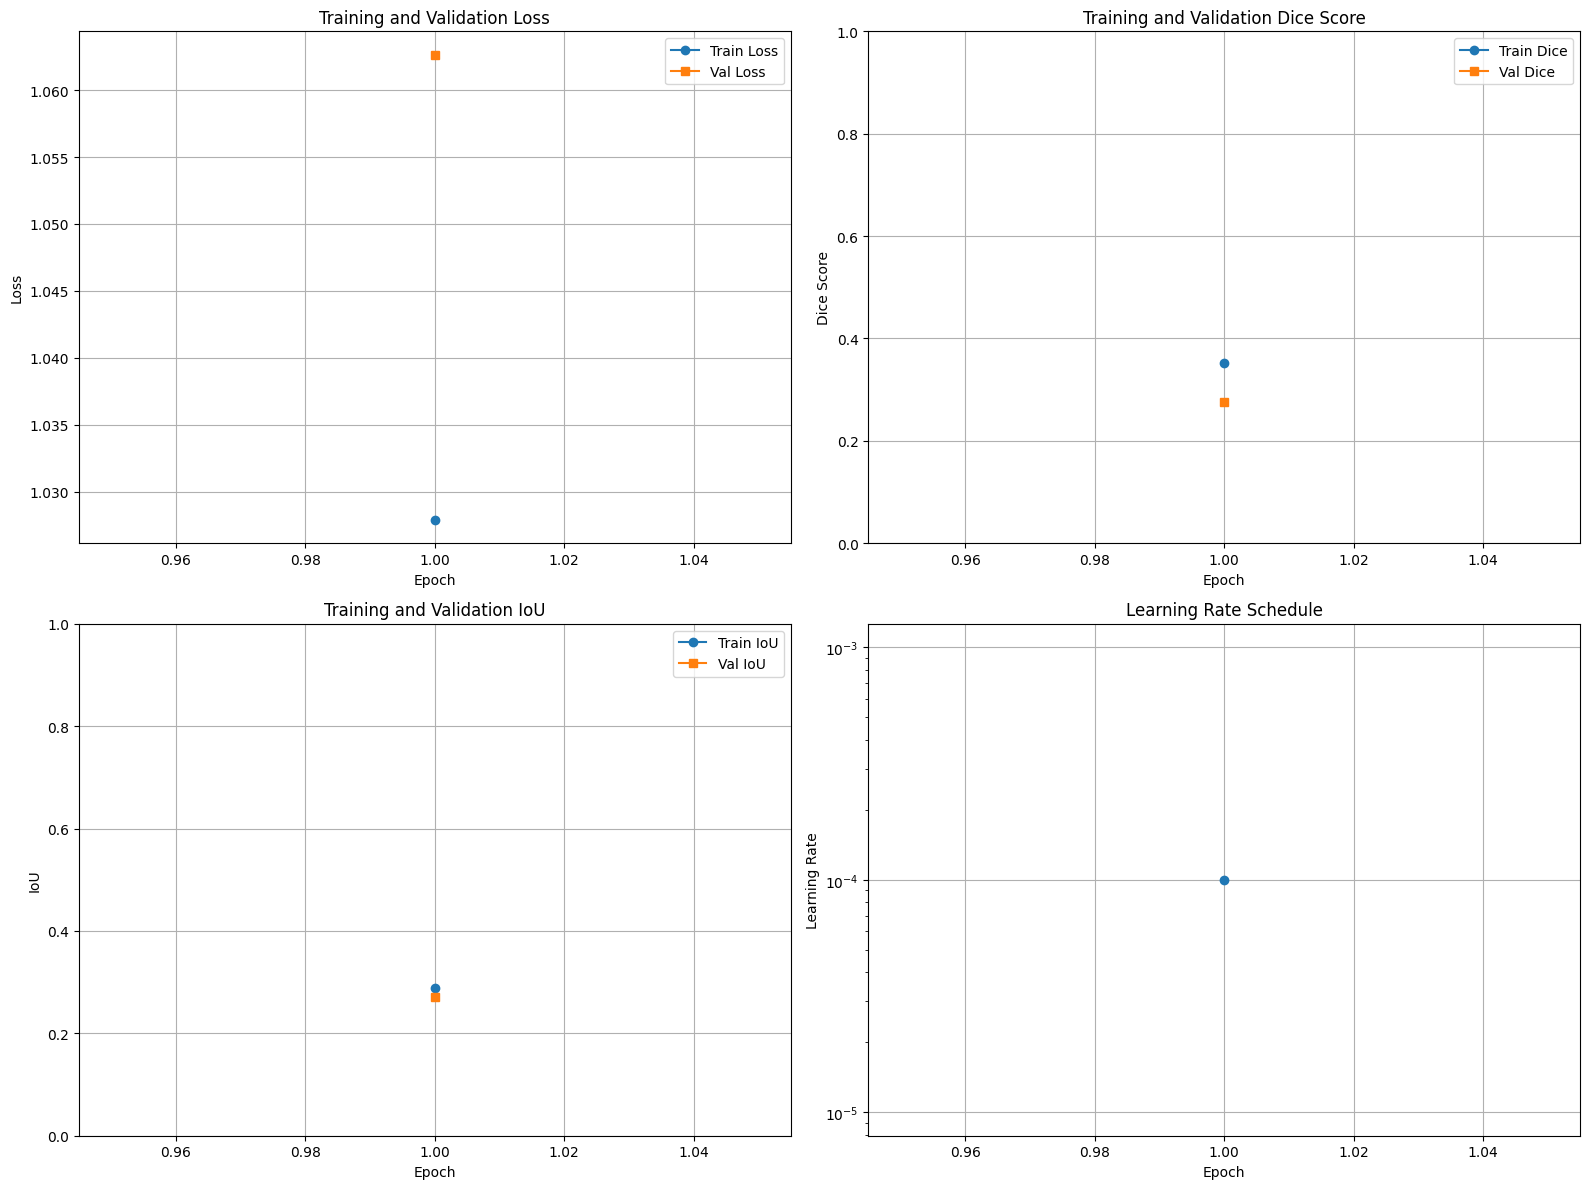


TRAINING SUMMARY
Total epochs:          1
Best validation Dice:  0.2756 (Epoch 1)
Final validation Dice: 0.2756
Best validation loss:  1.0626 (Epoch 1)
Final validation loss: 1.0626
Total training time:   0.03 hours
Avg time per epoch:    1.96 minutes


In [10]:
detailed_history = {
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'train_dice': history['train_dice'],
    'val_dice': history['val_dice'],
    'train_iou': history['train_iou'],
    'val_iou': history['val_iou'],
    'epoch_train_times': history['epoch_train_times'],
    'learning_rates': history['learning_rates'],
}

plot_detailed_training_history(
    history=detailed_history,
    save_path=f'assets/{MODEL_NAME}/detailed_training_history.png'
)

In [11]:
# Save history to JSON
history_to_json(
    history=detailed_history,
    model_name=MODEL_NAME,
    save_dir='logs',
    # Configuration parameters
    batch_size=BATCH_SIZE,
    num_slices=N_SLICES,  # Nur wenn 2.5D verwendet wird
    slice_range=SLICE_RANGE,
    num_epochs=NUM_EPOCHS,
    optimizer='Adam',
    loss_function='CombinedLoss',
    model_type='UNet',
    dataset_type='2D',  # oder '2.5D'
)

✓ Saved training history to logs/v1_25d_history.json


'logs/v1_25d_history.json'

## 10. Evaluate on Test Set

In [12]:
# Load best model checkpoint
checkpoint = load_checkpoint(model, MODEL_SAVE_PATH, device=device)
epoch = checkpoint.get('epoch', 0)
val_dice = checkpoint.get('val_dice', None)
val_iou = checkpoint.get('val_iou', None)
print(f"Loaded best model from epoch {epoch + 1}")
print(f"Val Dice: {val_dice:.4f}")
print(f"Val IoU: {val_iou:.4f}")

# Import validate function for testing
from utils.training import validate

# Evaluate on test set with both metrics
test_loss, test_metrics = validate(
    model, test_loader, criterion, device, 
    metric_fns={'dice': dice_score, 'iou': iou_score}
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_metrics['dice']:.4f}")
print(f"Test IoU Score: {test_metrics['iou']:.4f}")

Loaded best model from epoch 1
Val Dice: 0.2756
Val IoU: 0.2712


Validation: 100%|██████████| 25/25 [00:41<00:00,  1.68s/it, loss=1.0641]


Test Loss: 1.0654
Test Dice Score: 0.2445
Test IoU Score: 0.2386


✓ Saved predictions to assets/v1_25d.pth/test_predictions.png


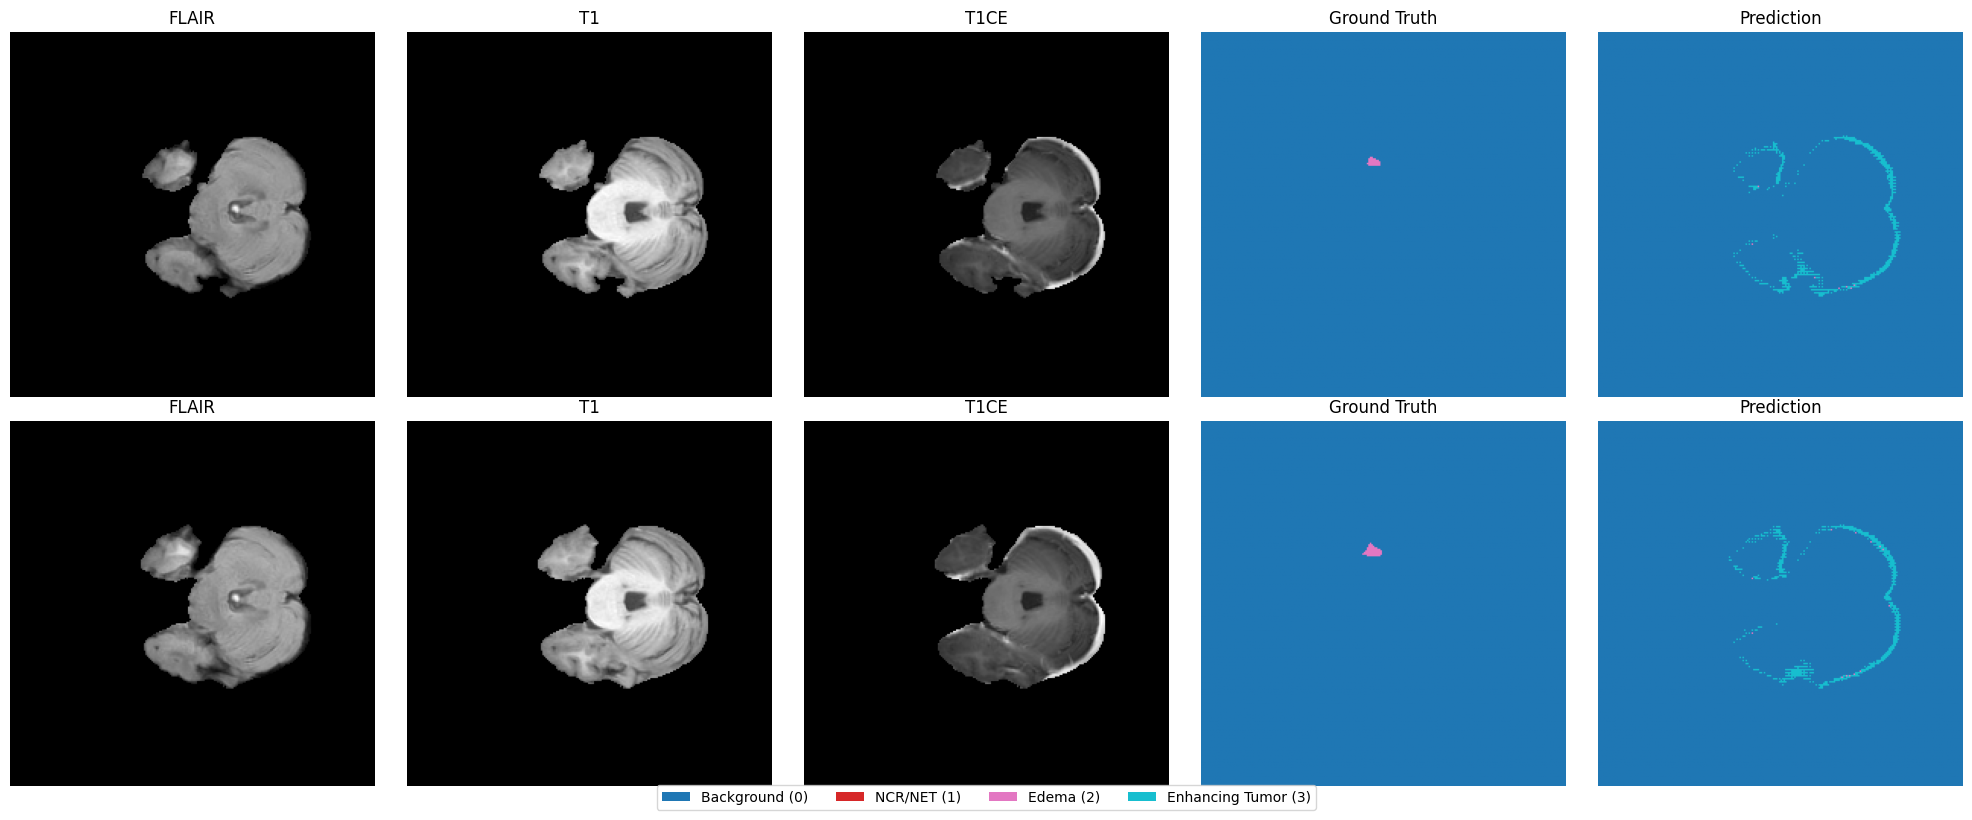

In [13]:
visualize_predictions(
    model=model,
    dataloader=test_loader,
    device=device,
    num_samples=2,
    save_path=f'assets/{MODEL_NAME}/test_predictions.png'
)

## 12. Overlay-Visualisierung

✓ Saved overlay visualization to assets/v1_25d.pth/overlay_sample_50.png


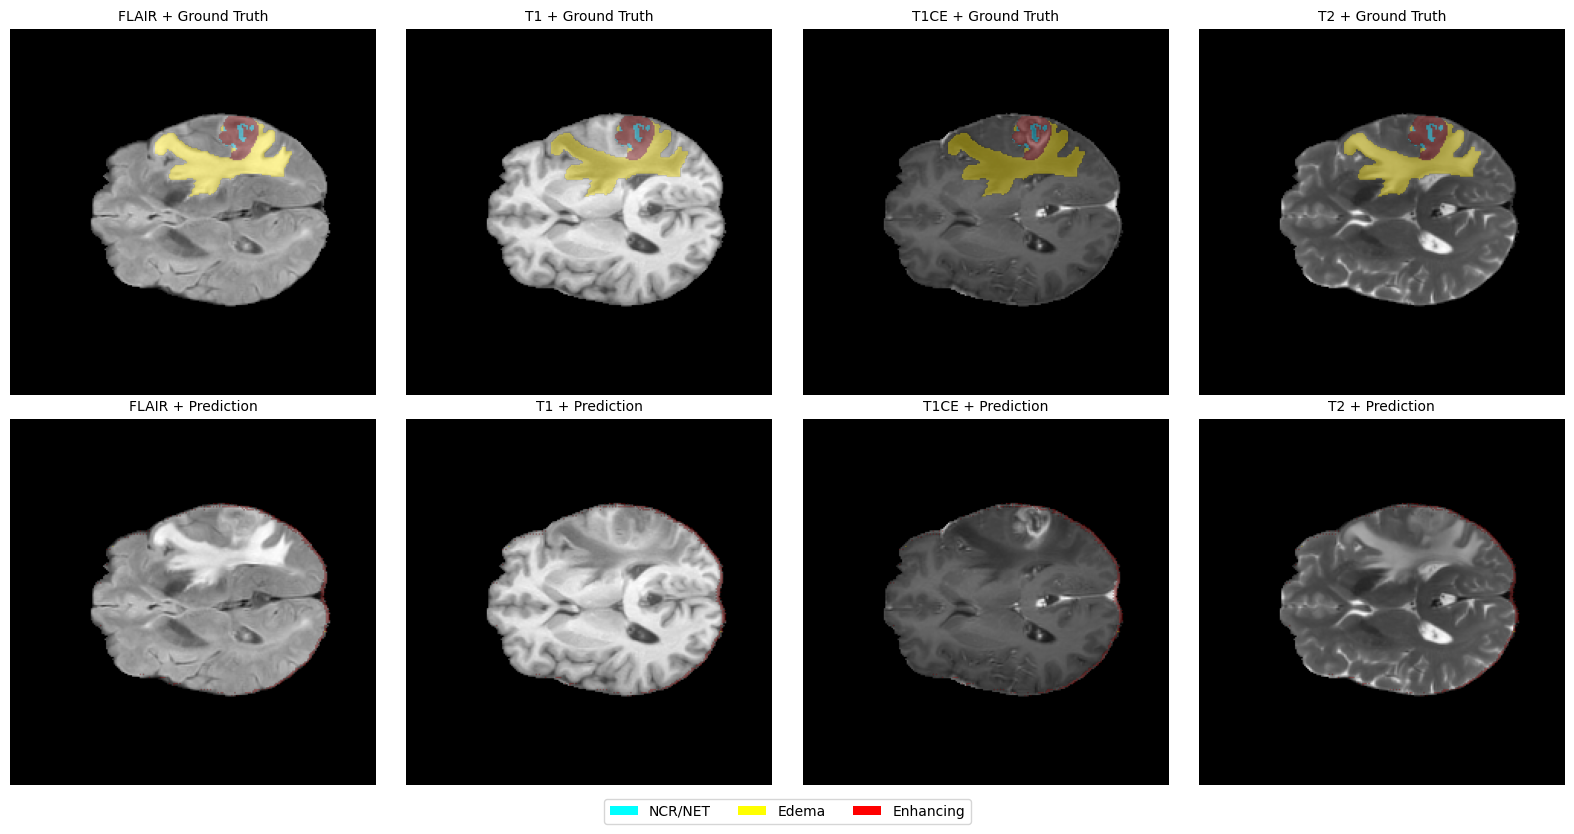

In [14]:
# Hole ein Sample aus dem Test-Set
model.eval()

# Wähle einen interessanten Slice aus dem Test-Datensatz
sample_idx = 50  # Du kannst den Index ändern um verschiedene Samples zu sehen

with torch.no_grad():
    # Hole Daten
    image, mask = test_dataset[sample_idx]
    image_batch = image.unsqueeze(0).to(device)
    
    # Generiere Vorhersage
    output = model(image_batch)
    prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Konvertiere zu numpy
    image_np = image.cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    # Visualisiere mit Overlay
    visualize_sample_with_overlay(
        image=image_np,
        mask=mask_np,
        prediction=prediction,
        alpha=0.4,  # Transparenz: 0.0 = voll transparent, 1.0 = voll opak
        save_path=f'assets/{MODEL_NAME}/overlay_sample_{sample_idx}.png'
    )